<a href="https://colab.research.google.com/github/mrifala29/Student-Performance-Classification-using-Feature-Selection-and-SMOTE-for-Imbalance-Data/blob/main/Classification_Student_Performance_Feature%20Selection_Imbalance%20Handling_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Library

In [ ]:
import pandas as pd
import math
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from scipy.stats import mstats

from sklearn.model_selection import train_test_split

from collections import Counter
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTENC

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

## Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preparation

Data and journals can be accessed here: [Download](https://drive.google.com/drive/folders/1eiHPSlf3rhl7J4-2HlRJOTbRWsUDbAuI?usp=sharing)

### Extract Data

In [ ]:
# !unzip /content/drive/MyDrive/Dataset/Student Performance/student+performance.zip -d /content/drive/MyDrive/Dataset/Student Performance/

### Check Data

In [ ]:
base_dir = '/content/drive/MyDrive/Dataset/Student Performance/'
data_desc = base_dir+'student.txt'

data_mat = base_dir+'student-mat.csv'
data_por = base_dir+'student-por.csv'

Explanation of features in the data

In [ ]:
with open(data_desc, 'r') as f:
  file_content = f.read()
print(file_content)

# Attributes for both student-mat.csv (Math course) and student-por.csv (Portuguese language course) datasets:
1 school - student's school (binary: "GP" - Gabriel Pereira or "MS" - Mousinho da Silveira)
2 sex - student's sex (binary: "F" - female or "M" - male)
3 age - student's age (numeric: from 15 to 22)
4 address - student's home address type (binary: "U" - urban or "R" - rural)
5 famsize - family size (binary: "LE3" - less or equal to 3 or "GT3" - greater than 3)
6 Pstatus - parent's cohabitation status (binary: "T" - living together or "A" - apart)
7 Medu - mother's education (numeric: 0 - none,  1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
8 Fedu - father's education (numeric: 0 - none,  1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
9 Mjob - mother's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or 

Sample data

In [ ]:
data_mat = pd.read_csv(data_mat, delimiter=';')
data_por = pd.read_csv(data_por, delimiter=';')

data = pd.concat([data_mat, data_por])
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [ ]:
data.tail()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
644,MS,F,19,R,GT3,T,2,3,services,other,...,5,4,2,1,2,5,4,10,11,10
645,MS,F,18,U,LE3,T,3,1,teacher,services,...,4,3,4,1,1,1,4,15,15,16
646,MS,F,18,U,GT3,T,1,1,other,other,...,1,1,1,1,1,5,6,11,12,9
647,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,6,10,10,10
648,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,4,10,11,11


## Exploratory Data Analysis

### Feature and Shape

Detail features of the data

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1044 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      1044 non-null   object
 1   sex         1044 non-null   object
 2   age         1044 non-null   int64 
 3   address     1044 non-null   object
 4   famsize     1044 non-null   object
 5   Pstatus     1044 non-null   object
 6   Medu        1044 non-null   int64 
 7   Fedu        1044 non-null   int64 
 8   Mjob        1044 non-null   object
 9   Fjob        1044 non-null   object
 10  reason      1044 non-null   object
 11  guardian    1044 non-null   object
 12  traveltime  1044 non-null   int64 
 13  studytime   1044 non-null   int64 
 14  failures    1044 non-null   int64 
 15  schoolsup   1044 non-null   object
 16  famsup      1044 non-null   object
 17  paid        1044 non-null   object
 18  activities  1044 non-null   object
 19  nursery     1044 non-null   object
 20  higher      10

Shapes of the data

In [ ]:
print("Jumlah data:",data.shape[0])
print("Jumlah kolom:",data.shape[1])

Jumlah data: 1044
Jumlah kolom: 33


Detail values of the data

In [ ]:
data.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000
mean,16.726054,2.603448,2.387931,1.522989,1.970307,0.264368,3.935824,3.201149,3.156130,1.494253,2.284483,3.543103,4.434866,11.213602,11.246169,11.341954
std,1.239975,1.124907,1.099938,0.731727,0.834353,0.656142,0.933401,1.031507,1.152575,0.911714,1.285105,1.424703,6.210017,2.983394,3.285071,3.864796
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,9.000000,9.000000,10.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


Data null

In [ ]:
data.isnull().sum()

,0
school,0
sex,0
age,0
address,0
famsize,0
Pstatus,0
Medu,0
Fedu,0
Mjob,0
Fjob,0


### Encoding Categorical Data

In [ ]:
object_columns = data.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()

for i in object_columns:
  data[i] = label_encoder.fit_transform(data[i])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1044 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   school      1044 non-null   int64
 1   sex         1044 non-null   int64
 2   age         1044 non-null   int64
 3   address     1044 non-null   int64
 4   famsize     1044 non-null   int64
 5   Pstatus     1044 non-null   int64
 6   Medu        1044 non-null   int64
 7   Fedu        1044 non-null   int64
 8   Mjob        1044 non-null   int64
 9   Fjob        1044 non-null   int64
 10  reason      1044 non-null   int64
 11  guardian    1044 non-null   int64
 12  traveltime  1044 non-null   int64
 13  studytime   1044 non-null   int64
 14  failures    1044 non-null   int64
 15  schoolsup   1044 non-null   int64
 16  famsup      1044 non-null   int64
 17  paid        1044 non-null   int64
 18  activities  1044 non-null   int64
 19  nursery     1044 non-null   int64
 20  higher      1044 non-null   int64
 2

In [ ]:
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,0,18,1,0,0,4,4,0,4,...,4,3,4,1,1,3,6,5,6,6
1,0,0,17,1,0,1,1,1,0,2,...,5,3,3,1,1,3,4,5,5,6
2,0,0,15,1,1,1,1,1,0,2,...,4,3,2,2,3,3,10,7,8,10
3,0,0,15,1,0,1,4,2,1,3,...,3,2,2,1,1,5,2,15,14,15
4,0,0,16,1,0,1,3,3,2,2,...,4,3,2,1,2,5,4,6,10,10


### Distribution Data

Distribution of the data

In [ ]:

for column in data.columns:
    print(f"Distribusi pada kolom '{column}':")
    print(data[column].value_counts())
    print("\n")

Distribusi pada kolom 'school':
school
0    772
1    272
Name: count, dtype: int64


Distribusi pada kolom 'sex':
sex
0    591
1    453
Name: count, dtype: int64


Distribusi pada kolom 'age':
age
16    281
17    277
18    222
15    194
19     56
20      9
21      3
22      2
Name: count, dtype: int64


Distribusi pada kolom 'address':
address
1    759
0    285
Name: count, dtype: int64


Distribusi pada kolom 'famsize':
famsize
0    738
1    306
Name: count, dtype: int64


Distribusi pada kolom 'Pstatus':
Pstatus
1    923
0    121
Name: count, dtype: int64


Distribusi pada kolom 'Medu':
Medu
4    306
2    289
3    238
1    202
0      9
Name: count, dtype: int64


Distribusi pada kolom 'Fedu':
Fedu
2    324
1    256
3    231
4    224
0      9
Name: count, dtype: int64


Distribusi pada kolom 'Mjob':
Mjob
2    399
3    239
0    194
4    130
1     82
Name: count, dtype: int64


Distribusi pada kolom 'Fjob':
Fjob
2    584
3    292
4     65
0     62
1     41
Name: count, dtype: int64


Di

Distribution of the target (dependent data)

<Axes: xlabel='G3', ylabel='Count'>

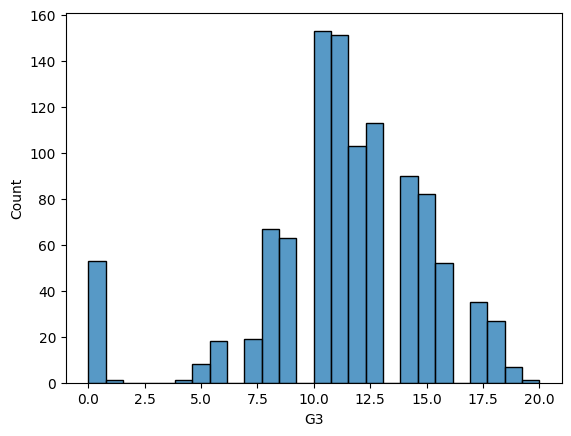

In [ ]:
sns.histplot(data['G3'])

<Axes: xlabel='absences', ylabel='Count'>

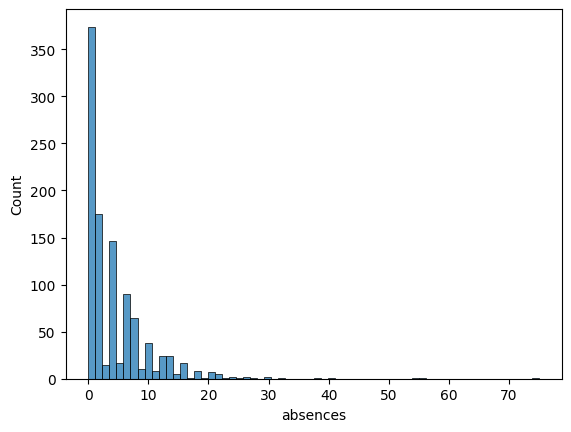

In [ ]:
sns.histplot(data['absences'])

<Axes: xlabel='G3'>

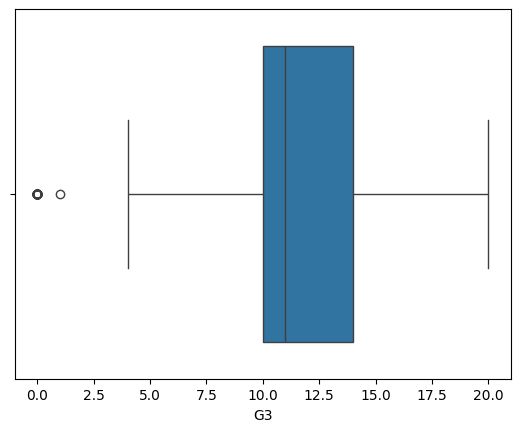

In [ ]:
sns.boxplot(x=data['G3'])

### Skewness Check

Skewness Check

In [ ]:
skew_results = pd.DataFrame({
    'column': data.columns,
    'skewness': [data[col].skew() for col in data.columns]
})

# Mengurutkan berdasarkan skewness tertinggi
skew_results = skew_results.sort_values(by='skewness', ascending=False).reset_index(drop=True)

# Menampilkan hasil
print(skew_results)

        column  skewness
0     absences  3.741347
1     failures  2.783660
2    schoolsup  2.432850
3         Dalc  2.157973
4         paid  1.420649
5   traveltime  1.369314
6       school  1.092702
7      famsize  0.910373
8    studytime  0.670982
9         Walc  0.625923
10    romantic  0.605253
11      reason  0.504489
12         age  0.434028
13         sex  0.267092
14        Fedu  0.119447
15          G1  0.077922
16       goout  0.038928
17  activities  0.023023
18        Medu -0.139528
19    guardian -0.162906
20    freetime -0.178707
21        Mjob -0.243876
22      famsup -0.464789
23        Fjob -0.469839
24          G2 -0.497357
25      health -0.498800
26          G3 -0.985965
27     address -1.020610
28      famrel -1.055775
29    internet -1.442022
30     nursery -1.500661
31     Pstatus -2.403286
32      higher -2.974719


<Axes: xlabel='failures', ylabel='Density'>

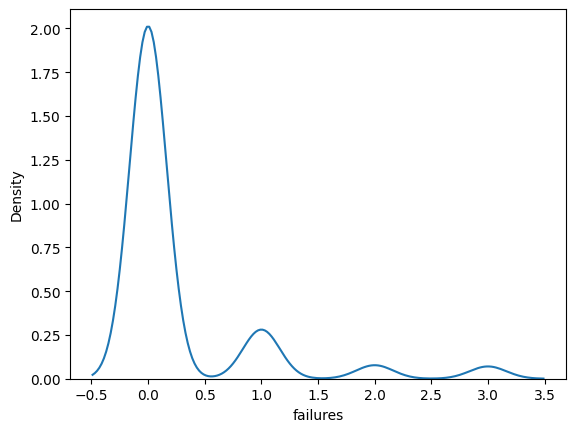

In [ ]:
sns.kdeplot(data['failures'])

<Axes: xlabel='absences', ylabel='Density'>

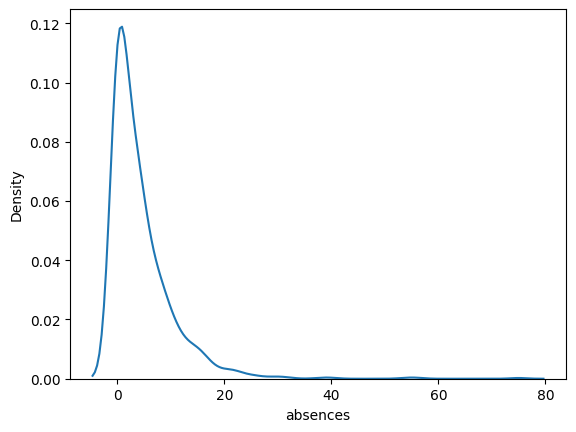

In [ ]:
sns.kdeplot(data['absences'])

<Axes: xlabel='schoolsup', ylabel='Density'>

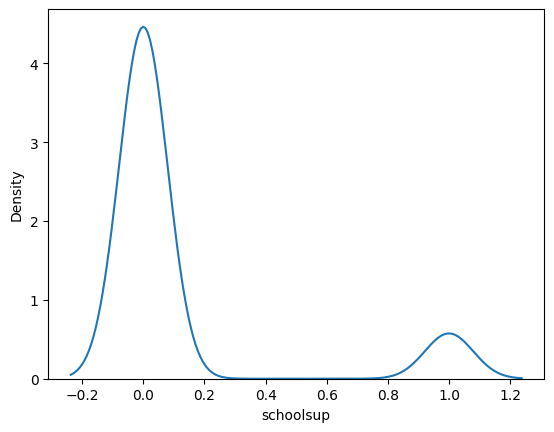

In [ ]:
sns.kdeplot(data['schoolsup'])

<Axes: xlabel='Dalc', ylabel='Density'>

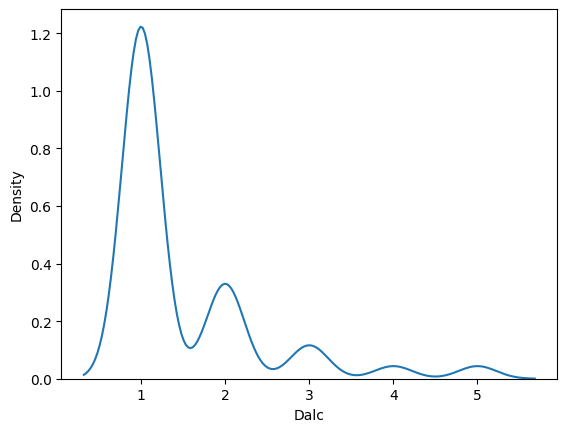

In [ ]:
sns.kdeplot(data['Dalc'])

<Axes: xlabel='higher', ylabel='Density'>

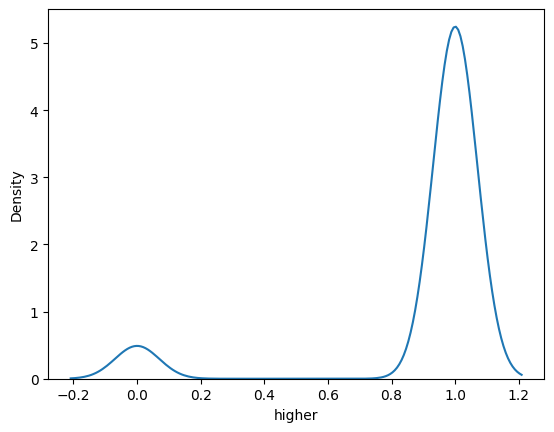

In [ ]:
sns.kdeplot(data['higher'])

<Axes: xlabel='Pstatus', ylabel='Density'>

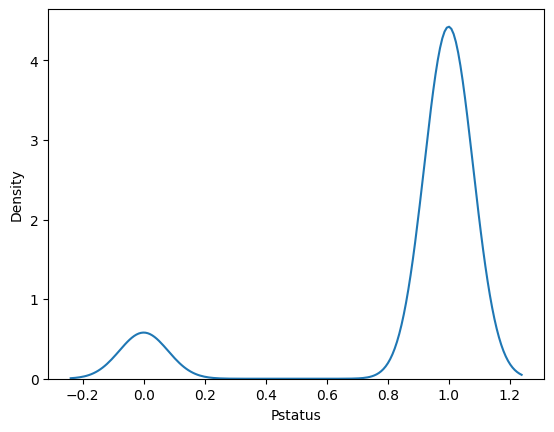

In [ ]:
sns.kdeplot(data['Pstatus'])

### Correlation Data

Correlation of the data

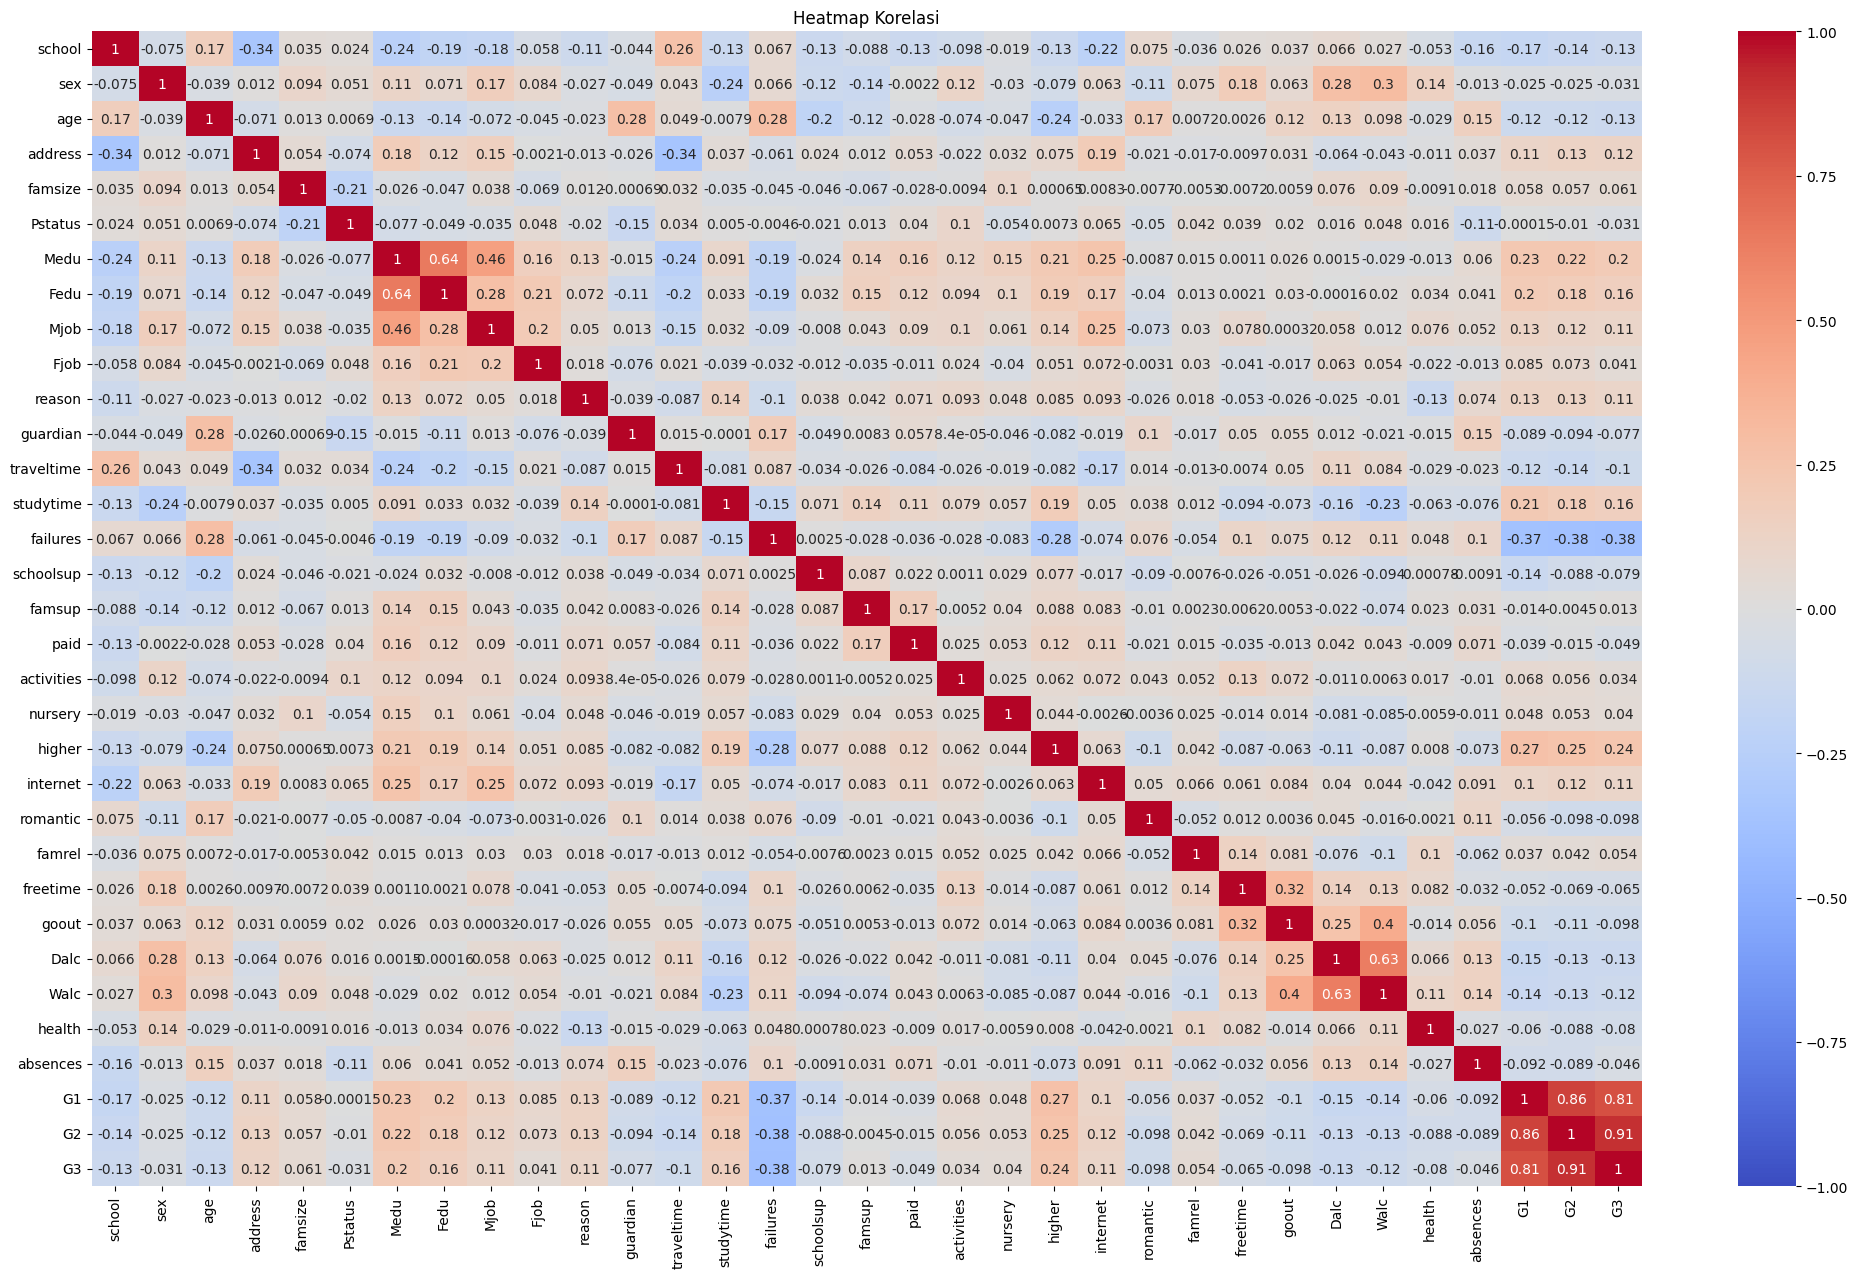

In [ ]:
correlation_matrix = data.corr()

plt.figure(figsize=(25, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Heatmap Korelasi')
plt.show()

### Categorical and Numerical Check

Distribution of Unique Value

In [ ]:
threshold = 10

categorical_columns = [col for col in data.columns if data[col].nunique() < threshold]
numerical_columns = [col for col in data.columns if col not in categorical_columns]

print("Kolom Kategorikal berdasarkan nilai unik:", categorical_columns)
print("Kolom Numerik:", numerical_columns)


Kolom Kategorikal berdasarkan nilai unik: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']
Kolom Numerik: ['absences', 'G1', 'G2', 'G3']


Value Range

In [ ]:
threshold_range = 10

categorical_columns = [col for col in data.columns if data[col].max() - data[col].min() < threshold_range]
numerical_columns = [col for col in data.columns if col not in categorical_columns]

print("Kolom Kategorikal berdasarkan rentang nilai:", categorical_columns)
print("Kolom Numerik:", numerical_columns)


Kolom Kategorikal berdasarkan rentang nilai: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']
Kolom Numerik: ['absences', 'G1', 'G2', 'G3']


## Preprocessing

### Transform Feature

Log

In [ ]:
# for col in ['Pstatus']:
#     data[col] = np.log1p(data[col] + abs(data[col].min()) + 1)
#     print(f'Skewness setelah transformasi {col}: {data[col].skew()}')

Yeo-Johnson Transformation

In [ ]:
pt = PowerTransformer(method='yeo-johnson')
for col in ['failures', 'Dalc']:
    data[col] = pt.fit_transform(data[[col]])
    print(f'Skewness setelah transformasi {col}: {data[col].skew()}')


Skewness setelah transformasi failures: 1.7106948988521113
Skewness setelah transformasi Dalc: 0.8821465253008904


1.7106948988521113


<Axes: xlabel='failures', ylabel='Density'>

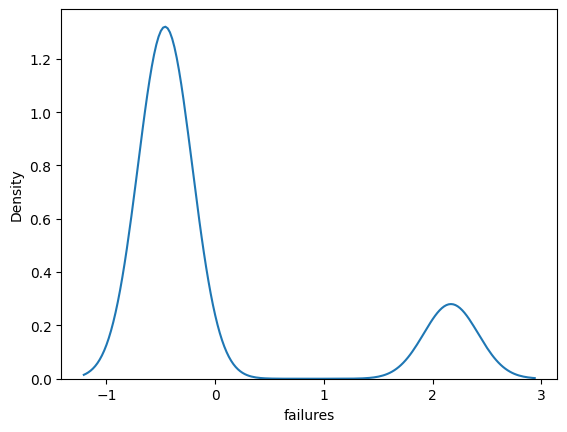

In [ ]:
print(data['failures'].skew())
sns.kdeplot(data['failures'])

0.8821465253008904


<Axes: xlabel='Dalc', ylabel='Density'>

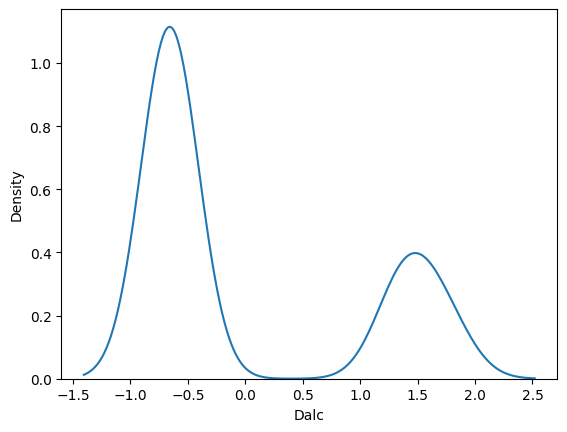

In [ ]:
print(data['Dalc'].skew())
sns.kdeplot(data['Dalc'])

Winsorizing

In [ ]:
for col in ['absences']:
    data[col] = mstats.winsorize(data[col], limits=[0, 0.2])
    print(f'Skewness setelah transformasi {col}: {data[col].skew()}')

Skewness setelah transformasi absences: 0.39033892604239556


0.39033892604239556


<Axes: xlabel='absences', ylabel='Density'>

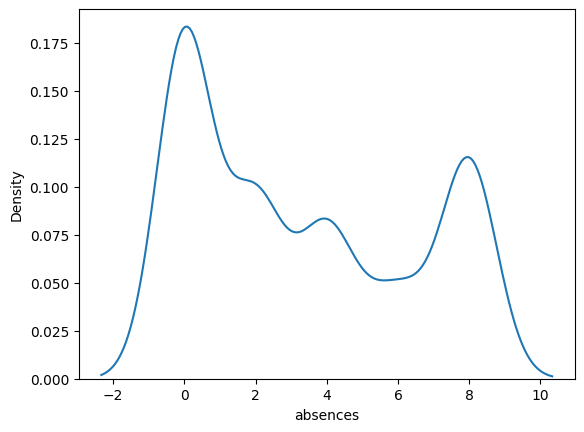

In [ ]:
print(data['absences'].skew())
sns.kdeplot(data['absences'])

### Convert Target (G3) to Categorical

G3 into 4 categories

In [ ]:
data.loc[(data.G3 >= 14) & (data.G3 <= 20), 'final_grade'] = 'tinggi'
data.loc[(data.G3 >= 7) & (data.G3 <= 13), 'final_grade'] = 'sedang'
data.loc[(data.G3 >= 0) & (data.G3 <= 6), 'final_grade'] = 'rendah'
data.head(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,final_grade
0,0,0,18,1,0,0,4,4,0,4,...,3,4,-0.657674,1,3,6,5,6,6,rendah
1,0,0,17,1,0,1,1,1,0,2,...,3,3,-0.657674,1,3,4,5,5,6,rendah
2,0,0,15,1,1,1,1,1,0,2,...,3,2,1.382154,3,3,8,7,8,10,sedang
3,0,0,15,1,0,1,4,2,1,3,...,2,2,-0.657674,1,5,2,15,14,15,tinggi
4,0,0,16,1,0,1,3,3,2,2,...,3,2,-0.657674,2,5,4,6,10,10,sedang


Encoding

In [ ]:
sch_map = {'rendah':0, 'sedang':1, 'tinggi':2}
data['final_grade'] = data['final_grade'].map(sch_map)

data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,final_grade
0,0,0,18,1,0,0,4,4,0,4,...,3,4,-0.657674,1,3,6,5,6,6,0
1,0,0,17,1,0,1,1,1,0,2,...,3,3,-0.657674,1,3,4,5,5,6,0
2,0,0,15,1,1,1,1,1,0,2,...,3,2,1.382154,3,3,8,7,8,10,1
3,0,0,15,1,0,1,4,2,1,3,...,2,2,-0.657674,1,5,2,15,14,15,2
4,0,0,16,1,0,1,3,3,2,2,...,3,2,-0.657674,2,5,4,6,10,10,1


Distribution of the data

<Axes: xlabel='final_grade', ylabel='count'>

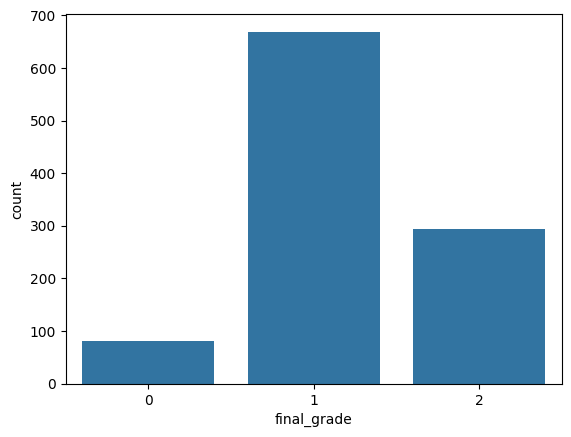

In [ ]:
sns.countplot(x=data['final_grade'])

In [ ]:
data['final_grade'].value_counts()

,count
final_grade,
1,669
2,294
0,81


### Standardization

Drop columns G3

In [ ]:
scaler = StandardScaler()

target = data['final_grade']
X = data.drop(columns=['G3', 'final_grade'])

scaler.fit(X)
data_std = scaler.transform(X)

data_std = pd.DataFrame(data_std, columns=data.columns[:-2])
data_std.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
0,-0.593575,-0.875498,1.027889,0.612776,-0.643921,-2.761901,1.242077,1.466302,-1.629761,2.031994,...,-0.742471,0.068788,-0.195099,0.732511,-0.657674,-0.999995,-0.381387,0.866365,-2.083727,-1.597738
1,-0.593575,-0.875498,0.221035,0.612776,-0.643921,0.362069,-1.426089,-1.262431,-1.629761,-0.285212,...,-0.742471,1.140653,-0.195099,-0.135527,-0.657674,-0.999995,-0.381387,0.224659,-2.083727,-1.902291
2,-0.593575,-0.875498,-1.392674,0.612776,1.552986,0.362069,-1.426089,-1.262431,-1.629761,-0.285212,...,-0.742471,0.068788,-0.195099,-1.003566,1.382154,0.557044,-0.381387,1.508072,-1.413029,-0.988631
3,-0.593575,-0.875498,-1.392674,0.612776,-0.643921,0.362069,1.242077,-0.352853,-0.826043,0.873391,...,1.346854,-1.003076,-1.165019,-1.003566,-0.657674,-0.999995,1.023086,-0.417048,1.269766,0.838688
4,-0.593575,-0.875498,-0.585820,0.612776,-0.643921,0.362069,0.352689,0.556724,-0.022325,-0.285212,...,-0.742471,0.068788,-0.195099,-1.003566,-0.657674,-0.221475,1.023086,0.224659,-1.748378,-0.379525


### Split Data

Split into 90% Training and 10% Testing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_std, target, test_size = 0.1, random_state = 42)

In [ ]:
print("Shape Data Train:", X_train.shape)
print("Shape Data Test:", X_test.shape)

Shape Data Train: (939, 32)
Shape Data Test: (105, 32)


## Handle Imbalance Data

### Visualization

In [ ]:
def visualize_data_after(y_train_resampled):
  print("Setelah SMOTE:", Counter(y_train_resampled))

  sns.countplot(x=y_train_resampled)
  plt.title('Sebaran data G3 setelah OverSampling')
  print("")

Sebelum Imbalance Handling
Setelah SMOTE: Counter({1: 599, 2: 265, 0: 75})



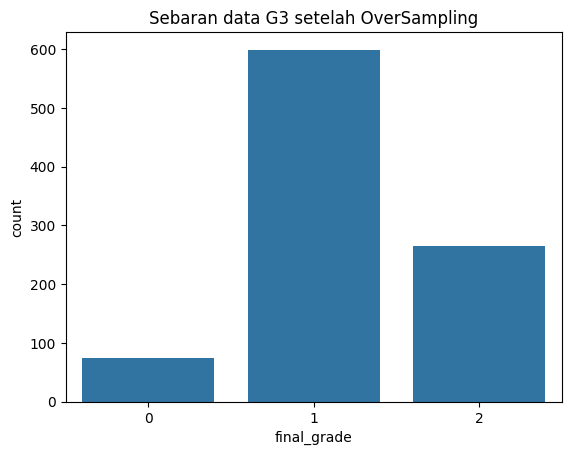

In [ ]:
print("Sebelum Imbalance Handling")
visualize_data_after(y_train)

### SMOTE - Borderline

In [ ]:
def smote_borderline(X_train, y_train):
  borderline_smote  = BorderlineSMOTE(random_state=42, kind='borderline-1')
  X_resampled_smoteb, y_resampled_smoteb = borderline_smote.fit_resample(X_train, y_train)

  return X_resampled_smoteb, y_resampled_smoteb

In [ ]:
X_resampled_smoteb, y_resampled_smoteb = smote_borderline(X_train, y_train)

OverSampling SMOTE-Borderline
Setelah SMOTE: Counter({2: 599, 1: 599, 0: 599})



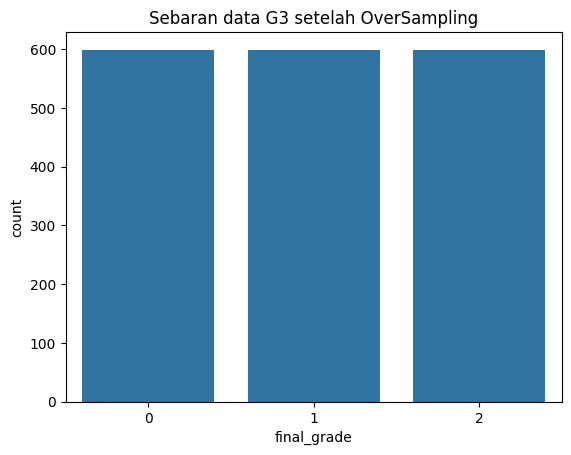

In [ ]:
print("OverSampling SMOTE-Borderline")
visualize_data_after(y_resampled_smoteb)

### SMOTE-NC

In [ ]:
def smote_nc(X_train, y_train):
  threshold = 10

  categorical_columns = [col for col in X_train.columns if X_train[col].nunique() < threshold] # ini dirubah ketika ganti feature selection
  numerical_columns = [col for col in X_train.columns if col not in categorical_columns] # ini dirubah ketika ganti feature selection

  print("Kolom Kategorikal berdasarkan nilai unik:", categorical_columns)
  print("Kolom Numerik:", numerical_columns)

  categorical_columns = [i for i in categorical_columns]
  categorical_feature_indices = [X_train.columns.get_loc(col) for col in categorical_columns]

  smotenc = SMOTENC(categorical_features=categorical_feature_indices, random_state=42)
  X_resampled_smotenc, y_resampled_smotenc = smotenc.fit_resample(X_train, y_train)

  return X_resampled_smotenc, y_resampled_smotenc

In [ ]:
X_resampled_smotenc, y_resampled_smotenc = smote_nc(X_train, y_train)

Kolom Kategorikal berdasarkan nilai unik: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Kolom Numerik: ['G1', 'G2']


OverSampling SMOTE-NC
Setelah SMOTE: Counter({2: 599, 1: 599, 0: 599})



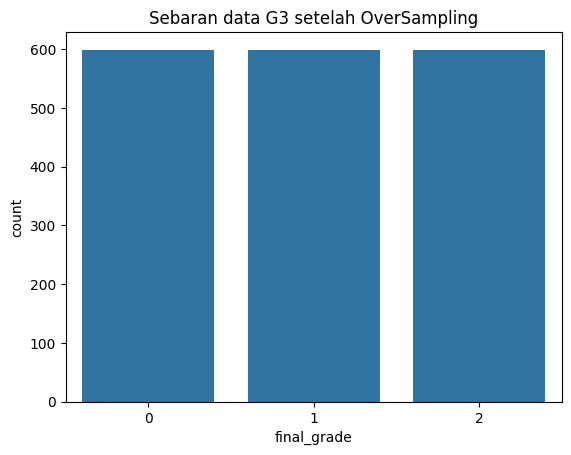

In [ ]:
print("OverSampling SMOTE-NC")
visualize_data_after(y_resampled_smotenc)

### ADASYN

In [ ]:
def adasyn(X_train, y_train):
  adasyn = ADASYN(random_state=42)
  X_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X_train, y_train)

  return X_resampled_adasyn, y_resampled_adasyn

In [ ]:
X_resampled_adasyn, y_resampled_adasyn = adasyn(X_train, y_train)

OverSampling ADASYN
Setelah SMOTE: Counter({2: 620, 1: 599, 0: 595})



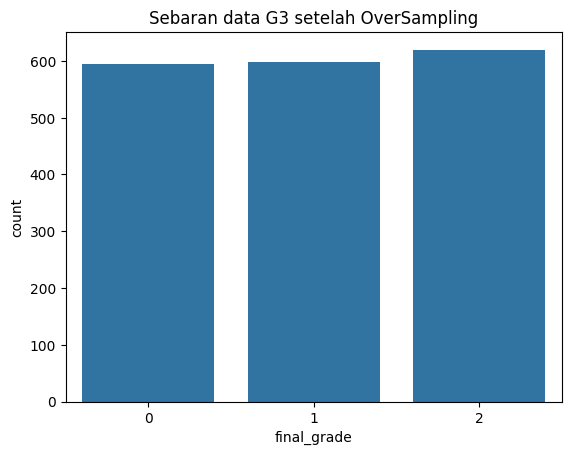

In [ ]:
print("OverSampling ADASYN")
visualize_data_after(y_resampled_adasyn)

## Feature Selection

### Filter - Annova Test

In [ ]:
def filter_anova(X, y):
  anova_selector = SelectKBest(score_func=f_classif, k=10)
  X_selected = anova_selector.fit_transform(X, y)
  selected_features = X.columns[anova_selector.get_support()]

  anova_scores = anova_selector.scores_
  feature_scores = pd.DataFrame({'Fitur': X.columns, 'ANOVA F-value': anova_scores})

  return selected_features

In [ ]:
selected_anova_smoteb = list(filter_anova(X_resampled_smoteb, y_resampled_smoteb))
selected_anova_smotenc = list(filter_anova(X_resampled_smotenc, y_resampled_smotenc))
selected_anova_adasyn = list(filter_anova(X_resampled_adasyn, y_resampled_adasyn))

print(selected_anova_smoteb[::-1])
print(selected_anova_smotenc[::-1])
print(selected_anova_adasyn[::-1])

['G2', 'G1', 'absences', 'higher', 'schoolsup', 'failures', 'studytime', 'Fedu', 'Medu', 'age']
['G2', 'G1', 'absences', 'Dalc', 'schoolsup', 'failures', 'studytime', 'Fedu', 'Medu', 'famsize']
['G2', 'G1', 'absences', 'Dalc', 'higher', 'schoolsup', 'failures', 'studytime', 'Fedu', 'Medu']


### Embbeded - Tree Importance

Training using Decision Tree

In [ ]:
def tree_importance(X, y):

  tree = DecisionTreeRegressor(random_state=42)

  tree.fit(X, y)

  feature_importances = tree.feature_importances_
  features = X.columns

  importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
  importance_df = importance_df.sort_values(by='Importance', ascending=False)

  first_10_column_names = importance_df['Feature'].iloc[:10].values.tolist()

  return first_10_column_names

In [ ]:
selected_tree_importance_smoteb = list(tree_importance(X_resampled_smoteb, y_resampled_smoteb))
selected_tree_importance_smotenc = list(tree_importance(X_resampled_smotenc, y_resampled_smotenc))
selected_tree_importance_adasyn = list(tree_importance(X_resampled_adasyn, y_resampled_adasyn))

print(selected_tree_importance_smoteb)
print(selected_tree_importance_smotenc)
print(selected_tree_importance_adasyn)

['G2', 'absences', 'G1', 'reason', 'Fjob', 'age', 'goout', 'address', 'studytime', 'internet']
['G2', 'absences', 'sex', 'reason', 'G1', 'Fjob', 'school', 'goout', 'age', 'Dalc']
['G2', 'absences', 'health', 'studytime', 'Fjob', 'G1', 'famrel', 'schoolsup', 'failures', 'reason']


Ranking of feature importance

In [ ]:
# plt.figure(figsize=(25, 15))
# plt.barh(importance_df['Feature'], importance_df['Importance'])
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.title('Feature Importance in Decision Tree')
# plt.gca().invert_yaxis()
# plt.show()

### Filter - Mutual Information

In [ ]:
def mutual_information(X, y):
  mutual_info_selector = SelectKBest(score_func=mutual_info_classif, k=10)
  X_selected = mutual_info_selector.fit_transform(X, y)

  selected_features = mutual_info_selector.get_support(indices=True)
  selected_features = data.columns[selected_features].tolist()
  selected_features = selected_features[::-1]

  return selected_features

In [ ]:
selected_mutual_information_smoteb = list(mutual_information(X_resampled_smoteb, y_resampled_smoteb))
selected_mutual_information_smotenc = list(mutual_information(X_resampled_smotenc, y_resampled_smotenc))
selected_mutual_information_adasyn = list(mutual_information(X_resampled_adasyn, y_resampled_adasyn))

print(selected_mutual_information_smoteb)
print(selected_mutual_information_smotenc)
print(selected_mutual_information_adasyn)

['G2', 'G1', 'absences', 'health', 'goout', 'failures', 'reason', 'Fedu', 'Medu', 'age']
['G2', 'G1', 'absences', 'health', 'Dalc', 'failures', 'studytime', 'Mjob', 'Fedu', 'Medu']
['G2', 'G1', 'absences', 'health', 'goout', 'failures', 'Mjob', 'Fedu', 'Medu', 'age']


### Wrapper - Backward Feature Selection

In [ ]:
def backward(X, y):
  with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        model = LogisticRegression(max_iter=80)
        sfs = SFS(model,
                  k_features=10,
                  forward=False,
                  floating=False,
                  scoring='accuracy',
                  verbose=1,
                  cv=5)
        sfs = sfs.fit(X, y)

        selected_features = list(sfs.k_feature_names_)

  return selected_features

In [ ]:
selected_backward_smoteb = list(backward(X_resampled_smoteb, y_resampled_smoteb))
selected_backward_smoteb = selected_backward_smoteb[::-1]

selected_backward_smotenc = list(backward(X_resampled_smotenc, y_resampled_smotenc))
selected_backward_smotenc = selected_backward_smotenc[::-1]

selected_backward_adasyn = list(backward(X_resampled_adasyn, y_resampled_adasyn))
selected_backward_adasyn = selected_backward_adasyn[::-1]

print(selected_backward_smoteb)
print(selected_backward_smotenc)
print(selected_backward_adasyn)

Features: 10/10

['G2', 'absences', 'nursery', 'paid', 'schoolsup', 'guardian', 'Fjob', 'Fedu', 'age', 'school']
['G2', 'absences', 'famrel', 'higher', 'paid', 'schoolsup', 'traveltime', 'Fedu', 'address', 'age']
['G2', 'absences', 'internet', 'higher', 'schoolsup', 'guardian', 'Fjob', 'address', 'age', 'school']


### Selected Feature

In [ ]:
def selected_feature(X_train, X_test, selected_features):
  X_train_selected = X_train[selected_features]
  X_test_selected = X_test[selected_features]

  return X_train_selected, X_test_selected

#### Anova

In [ ]:
data_anova_smoteb = selected_feature(X_resampled_smoteb, X_test, selected_anova_smoteb)
data_anova_smotenc = selected_feature(X_resampled_smotenc, X_test, selected_anova_smotenc)
data_anova_adasyn = selected_feature(X_resampled_adasyn, X_test, selected_anova_adasyn)

#### Tree Importance

In [ ]:
data_tree_importance_smoteb = selected_feature(X_resampled_smoteb, X_test, selected_tree_importance_smoteb)
data_tree_importance_smotenc = selected_feature(X_resampled_smotenc, X_test, selected_tree_importance_smotenc)
data_tree_importance_adasyn = selected_feature(X_resampled_adasyn, X_test, selected_tree_importance_adasyn)

#### Mutual Information

In [ ]:
data_mutual_information_smoteb = selected_feature(X_resampled_smoteb, X_test, selected_mutual_information_smoteb)
data_mutual_information_smotenc = selected_feature(X_resampled_smotenc, X_test, selected_mutual_information_smotenc)
data_mutual_information_adasyn = selected_feature(X_resampled_adasyn, X_test, selected_mutual_information_adasyn)

#### Backward

In [ ]:
data_backward_smoteb = selected_feature(X_resampled_smoteb, X_test, selected_backward_smoteb)
data_backward_smotenc = selected_feature(X_resampled_smotenc, X_test, selected_backward_smotenc)
data_backward_adasyn = selected_feature(X_resampled_adasyn, X_test, selected_backward_adasyn)

## Modelling

In [ ]:
def evaluation_classification_report(y_test, y_pred):
  target_names = ['0', '1', '2']
  print(classification_report(y_test, y_pred, target_names=target_names))

### XGBoost

In [ ]:
def XGBoost(X_train_selected, X_test_selected, y_resampled):
  class_weights = {0:3, 1:2, 2:1}
  sample_weights = np.array([class_weights[label] for label in y_resampled])

  xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
  xgb_model.fit(X_train_selected, y_resampled, sample_weight=sample_weights)
  # xgb_model.fit(X_train_selected, y_resampled)
  y_pred = xgb_model.predict(X_test_selected)

  accuracy = accuracy_score(y_test, y_pred)
  print(f'Akurasi: {accuracy*100:.2f}%')
  print(f'Precision: {precision_score(y_test, y_pred, average="weighted")*100:.2f}%')
  print(f'Recall: {recall_score(y_test, y_pred, average="weighted")*100:.2f}%')
  print(f'F1-Score: {f1_score(y_test, y_pred, average="weighted")*100:.2f}%')

  return evaluation_classification_report(y_test, y_pred)

#### Anova

In [ ]:
print("Skenario 1")
XGBoost(data_anova_smoteb[0], data_anova_smoteb[1], y_resampled_smoteb)

Skenario 1
Akurasi: 86.67%
Precision: 88.89%
Recall: 86.67%
F1-Score: 87.64%
              precision    recall  f1-score   support

           0       0.22      0.33      0.27         6
           1       0.90      0.90      0.90        70
           2       1.00      0.90      0.95        29

    accuracy                           0.87       105
   macro avg       0.71      0.71      0.70       105
weighted avg       0.89      0.87      0.88       105



In [ ]:
print("Skenario 5")
XGBoost(data_anova_smotenc[0], data_anova_smotenc[1], y_resampled_smotenc)

Skenario 5
Akurasi: 89.52%
Precision: 90.97%
Recall: 89.52%
F1-Score: 90.08%
              precision    recall  f1-score   support

           0       0.44      0.67      0.53         6
           1       0.93      0.91      0.92        70
           2       0.96      0.90      0.93        29

    accuracy                           0.90       105
   macro avg       0.78      0.83      0.79       105
weighted avg       0.91      0.90      0.90       105



In [ ]:
print("Skenario 9")
XGBoost(data_anova_adasyn[0], data_anova_adasyn[1], y_resampled_adasyn)

Skenario 9
Akurasi: 90.48%
Precision: 90.56%
Recall: 90.48%
F1-Score: 90.48%
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         6
           1       0.92      0.94      0.93        70
           2       0.96      0.90      0.93        29

    accuracy                           0.90       105
   macro avg       0.79      0.78      0.79       105
weighted avg       0.91      0.90      0.90       105



#### Tree Impontance

In [ ]:
print("Skenario 4")
XGBoost(data_tree_importance_smoteb[0], data_tree_importance_smoteb[1], y_resampled_smoteb)

Skenario 4
Akurasi: 92.38%
Precision: 92.76%
Recall: 92.38%
F1-Score: 92.54%
              precision    recall  f1-score   support

           0       0.57      0.67      0.62         6
           1       0.94      0.94      0.94        70
           2       0.96      0.93      0.95        29

    accuracy                           0.92       105
   macro avg       0.83      0.85      0.84       105
weighted avg       0.93      0.92      0.93       105



In [ ]:
print("Skenario 8")
XGBoost(data_tree_importance_smotenc[0], data_tree_importance_smotenc[1], y_resampled_smotenc)

Skenario 8
Akurasi: 90.48%
Precision: 91.32%
Recall: 90.48%
F1-Score: 90.82%
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         6
           1       0.94      0.91      0.93        70
           2       0.93      0.93      0.93        29

    accuracy                           0.90       105
   macro avg       0.79      0.84      0.81       105
weighted avg       0.91      0.90      0.91       105



In [ ]:
print("Skenario 12")
XGBoost(data_tree_importance_adasyn[0], data_tree_importance_adasyn[1], y_resampled_adasyn)

Skenario 12
Akurasi: 88.57%
Precision: 90.00%
Recall: 88.57%
F1-Score: 89.22%
              precision    recall  f1-score   support

           0       0.25      0.33      0.29         6
           1       0.91      0.91      0.91        70
           2       1.00      0.93      0.96        29

    accuracy                           0.89       105
   macro avg       0.72      0.73      0.72       105
weighted avg       0.90      0.89      0.89       105



#### Mutual Information

In [ ]:
print("Skenario 2")
XGBoost(data_mutual_information_smoteb[0], data_mutual_information_smoteb[1], y_resampled_smoteb)

Skenario 2
Akurasi: 93.33%
Precision: 93.80%
Recall: 93.33%
F1-Score: 93.51%
              precision    recall  f1-score   support

           0       0.57      0.67      0.62         6
           1       0.94      0.96      0.95        70
           2       1.00      0.93      0.96        29

    accuracy                           0.93       105
   macro avg       0.84      0.85      0.84       105
weighted avg       0.94      0.93      0.94       105



In [ ]:
print("Skenario 6")
XGBoost(data_mutual_information_smotenc[0], data_mutual_information_smotenc[1], y_resampled_smotenc)

Skenario 6
Akurasi: 89.52%
Precision: 91.74%
Recall: 89.52%
F1-Score: 90.36%
              precision    recall  f1-score   support

           0       0.40      0.67      0.50         6
           1       0.93      0.91      0.92        70
           2       1.00      0.90      0.95        29

    accuracy                           0.90       105
   macro avg       0.78      0.83      0.79       105
weighted avg       0.92      0.90      0.90       105



In [ ]:
print("Skenario 10")
XGBoost(data_mutual_information_adasyn[0], data_mutual_information_adasyn[1], y_resampled_adasyn)

Skenario 10
Akurasi: 89.52%
Precision: 90.97%
Recall: 89.52%
F1-Score: 90.08%
              precision    recall  f1-score   support

           0       0.44      0.67      0.53         6
           1       0.93      0.91      0.92        70
           2       0.96      0.90      0.93        29

    accuracy                           0.90       105
   macro avg       0.78      0.83      0.79       105
weighted avg       0.91      0.90      0.90       105



#### Backward

In [ ]:
print("Skenario 3")
XGBoost(data_backward_smoteb[0], data_backward_smoteb[1], y_resampled_smoteb)

Skenario 3
Akurasi: 88.57%
Precision: 90.48%
Recall: 88.57%
F1-Score: 89.35%
              precision    recall  f1-score   support

           0       0.33      0.50      0.40         6
           1       0.91      0.91      0.91        70
           2       1.00      0.90      0.95        29

    accuracy                           0.89       105
   macro avg       0.75      0.77      0.75       105
weighted avg       0.90      0.89      0.89       105



In [ ]:
print("Skenario 7")
XGBoost(data_backward_smotenc[0], data_backward_smotenc[1], y_resampled_smotenc)

Skenario 7
Akurasi: 83.81%
Precision: 86.99%
Recall: 83.81%
F1-Score: 85.02%
              precision    recall  f1-score   support

           0       0.27      0.50      0.35         6
           1       0.92      0.83      0.87        70
           2       0.87      0.93      0.90        29

    accuracy                           0.84       105
   macro avg       0.69      0.75      0.71       105
weighted avg       0.87      0.84      0.85       105



In [ ]:
print("Skenario 11")
XGBoost(data_backward_adasyn[0], data_backward_adasyn[1], y_resampled_adasyn)

Skenario 11
Akurasi: 92.38%
Precision: 92.51%
Recall: 92.38%
F1-Score: 92.40%
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         6
           1       0.93      0.96      0.94        70
           2       1.00      0.93      0.96        29

    accuracy                           0.92       105
   macro avg       0.81      0.80      0.80       105
weighted avg       0.93      0.92      0.92       105

